# Adaptive-Additive Algorithm Test - 30/09

In [4]:
import detect_heds_module_path
from holoeye import slmdisplaysdk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import time
from pypylon import pylon

shape is:  (1080, 1920)
dataWidth = 1920
dataHeight = 1080
[[1.47135322 4.42207008 2.75096237 ... 0.38900405 0.53437548 2.64806578]
 [2.73964452 5.54282715 4.91808969 ... 2.66289558 5.71923947 4.60345295]
 [2.00093085 4.1669892  5.23297676 ... 3.81320819 0.27964533 5.54553305]
 ...
 [2.27198293 2.22582761 2.59252608 ... 3.13091956 5.99580807 2.07677335]
 [1.80019422 4.08459235 1.32936549 ... 4.46722583 2.39737147 3.66561328]
 [2.07922581 4.26086966 5.30902122 ... 0.81542026 2.17792628 4.36335652]]
(1080, 1920)


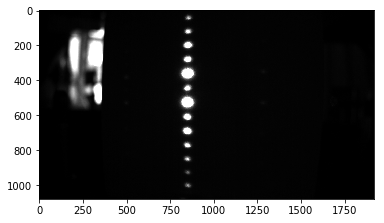

In [40]:
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()
#new_width = camera.Width.GetValue() - camera.Width.GetInc()
#if new_width >= camera.Width.GetMin():
#    camera.Width.SetValue(new_width)

# Make some enumerations available locally to avoid too much code:
ErrorCode = slmdisplaysdk.SLMDisplay.ErrorCode
ShowFlags = slmdisplaysdk.SLMDisplay.ShowFlags

# Initializes the SLM library
slm = slmdisplaysdk.SLMDisplay()

# Check if the library implements the required version
if not slm.requiresVersion(2):
    exit(1)

# Detect SLMs and open a window on the selected SLM
error = slm.open()
assert error == ErrorCode.NoError, slm.errorString(error)

# Open the SLM preview window in "Fit" mode:
# Please adapt the file showSLMPreview.py if preview window
# is not at the right position or even not visible.
from showSLMPreview import showSLMPreview
#showSLMPreview(slm, scale=0.0)

# Calculate e.g. a vertical blazed grating:
#blazePeriod = 77

# Reserve memory for the data:
dataWidth = slm.width_px
dataHeight = slm.height_px
data = slmdisplaysdk.createFieldUChar(dataWidth, dataHeight)
#print(data)
print("shape is: ", data.shape)
print("dataWidth = " + str(dataWidth))
print("dataHeight = " + str(dataHeight))

# Calculate the data:
data = 2*np.pi*np.random.uniform(0,255,(dataHeight, dataWidth))/255
print(data)
#Change Threshold
COST = 999999999999999999
Threshold = 0.1
a = 0.5
def cost(I_target, I_camera):
    return np.sum((abs(I_target-I_camera))**2)/np.size(I_target)

# Set this appropriately, can load the .npy file into this, and resize probably
TargetIntensity = np.load('target_intensity_02_10.npy')

print(TargetIntensity.shape)
plt.imshow(TargetIntensity, cmap='gray', vmin=0, vmax=255)
plt.show()    

In [52]:
numberOfImagesToGrab = 1000
iter = 0
new_target = TargetIntensity.T
camera.StartGrabbingMax(numberOfImagesToGrab)
time_start = time.time()
while camera.IsGrabbing() and (COST>Threshold):
    error = slm.showData(data)
    grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)

    if grabResult.GrabSucceeded():
        # Access the image data.
        img = (np.asarray(grabResult.Array))**0.5 #.reshape((grabResult.Height, grabResult.Width))
        img_sliced = img[0:1080, 0:1920]
        new_img = img_sliced.T
        COST = cost(new_target, new_img**2)

        
        img_fb = np.fft.fftshift(np.fft.ifft2((a*new_img+(1-a)*(new_target)**0.5)*(np.cos(data) + 1j*np.sin(data)))) # Multiplying phase mask to output electric field amplitude
        img_fb_phase = np.angle(img_fb)

        #print(img.shape)
        #print(data.shape)
        #img_fb_phase.T

        data = img_fb_phase
        iter = iter + 1

    time2 = time.time()
    #print("TIME: ", time2-time_start)
    ##Wait statements
    #time.sleep(5)
    #input("Press Enter to continue...")

    grabResult.Release()
    
print("TIME: ", time2-time_start)
print("Converged in ", iter , " iterations")

TIME:  160.34797954559326
Converged in  10  iterations


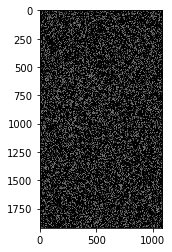

In [53]:
data = data*255/(2*np.pi)
plt.imshow(data, cmap='gray', vmin=0, vmax=255)
np.save('algo_test_result', data)

In [7]:
camera.Close()

# If your IDE terminates the python interpreter process after the script is finished, the SLM content
# will be lost as soon as the script finishes.
# You may insert further code here.
slm.close()
# Wait until the SLM process is closed:
error = slm.utilsWaitUntilClosed()
assert error == ErrorCode.NoError, slm.errorString(error)
# Unloading the SDK may or may not be required depending on your IDE:
slm = None


NameError: name 'camera' is not defined

In [31]:
print(data.shape)
print(img_sliced.shape)
print(TargetIntensity.shape)

(1920, 1080)
(1080, 1920)
(1080, 1920)


In [56]:
import os
cwd = os.getcwd()
print(cwd)

C:\Users\Ramesh


# Tests run on 02/10/2020

[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [128. 128. 128. ... 128. 128. 128.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [128. 128. 128. ... 128. 128. 128.]
 [128. 128. 128. ... 128. 128. 128.]]
(1080, 1920)


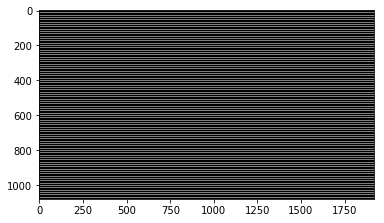

In [41]:
#target_phase = np.fromfile('target_phase_mask.dat.dat', dtype=np.int64)
target_phase = np.loadtxt('target_phase_mask.dat.dat')
print(target_phase)
print(target_phase.shape)
plt.imshow(target_phase, cmap='gray', vmin=0, vmax=255)
plt.show()

In [42]:
numberOfImagesToGrab = 50
target_phase = 2*np.pi*target_phase/255
data_init = data
data_error = []
data_error.append(cost(data_init, target_phase))
intensity_error = []
iter = 0
#new_target = TargetIntensity.T
time_start = time.time()
Threshold = 1
while iter in range(numberOfImagesToGrab) and (COST>Threshold):
    error = slm.showData(data)
    
    time.sleep(5)
    #input("Press Enter to continue...")
    
    camera.StartGrabbingMax(1)
    while camera.IsGrabbing():
        grabResult = camera.RetrieveResult(20000, pylon.TimeoutHandling_ThrowException)
        if grabResult.GrabSucceeded():
            # Access the image data.
            img = (np.asarray(grabResult.Array))**0.5 #.reshape((grabResult.Height, grabResult.Width))
        else:
            print("Error: ", grabResult.ErrorCode, grabResult.ErrorDescription)
        grabResult.Release()
            
            
    img_sliced = img[4:1084, 64:1984]
    
    COST = cost(TargetIntensity, img_sliced**2)
    intensity_error.append(COST)           
    
    img_fb = np.fft.fftshift(np.fft.ifft2((a*img_sliced+(1-a)*(TargetIntensity)**0.5)*(np.cos(data) + 1j*np.sin(data)))) # Multiplying phase mask to output electric field amplitude
    img_fb_phase = np.angle(img_fb)           

    data = img_fb_phase
    data = data%(2*np.pi)
    #data = ((255*data/(2*np.pi))%256)*2*np.pi/255
    data_error.append(cost(target_phase, data))
    iter = iter + 1    

    time2 = time.time()
    

print(data.shape)
print("TIME: ", time2-time_start)
print("Converged in ", iter , " iterations")

(1080, 1920)
TIME:  459.62738132476807
Converged in  50  iterations


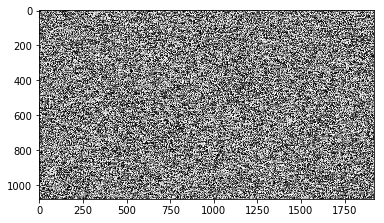

In [43]:
data = data*255/(2*np.pi)
plt.imshow(data, cmap='gray', vmin=0, vmax=255)
plt.show()
np.save('algo_test_result_02_10', data)

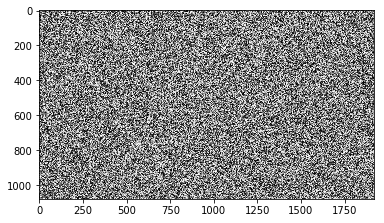

1.5935527240732963e+17
0.0
0.0


In [51]:
data_init = data_init*255/(2*np.pi)
plt.imshow(data_init, cmap='gray')
plt.show()
print(cost(data, data_init))
print(cost(data, data))
print(cost(data_init, data_init))

(1080, 1920)


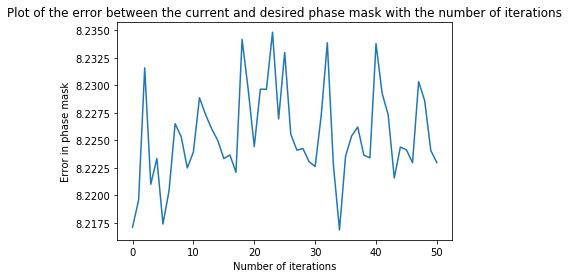

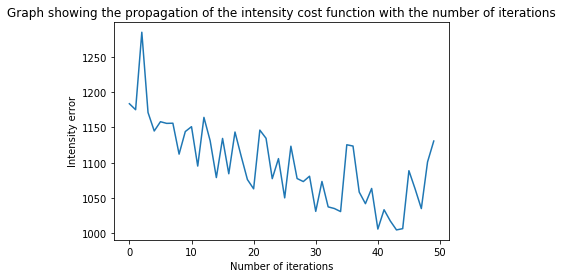

<Figure size 432x288 with 0 Axes>

In [52]:
print(data_init.shape)
n = np.arange(0,51,1)
plt.plot(n, data_error)
plt.xlabel('Number of iterations')
plt.ylabel('Error in phase mask')
plt.title('Plot of the error between the current and desired phase mask with the number of iterations')
plt.show()
plt.savefig('mask_error_02_10.png')

m = np.arange(0,50,1)
plt.plot(m, intensity_error)
plt.xlabel('Number of iterations')
plt.ylabel('Intensity error')
plt.title('Graph showing the propagation of the intensity cost function with the number of iterations')
plt.show()
plt.savefig('intensity_error_02_10.png')

In [50]:
print(cost(TargetIntensity, img_sliced**2))

1130.7909230324074


# Tests run on 05/10

In [5]:
# Make some enumerations available locally to avoid too much code:
ErrorCode = slmdisplaysdk.SLMDisplay.ErrorCode
ShowFlags = slmdisplaysdk.SLMDisplay.ShowFlags

# Initializes the SLM library
slm = slmdisplaysdk.SLMDisplay()

# Check if the library implements the required version
if not slm.requiresVersion(2):
    exit(1)

# Detect SLMs and open a window on the selected SLM
error = slm.open()
assert error == ErrorCode.NoError, slm.errorString(error)

# Open the SLM preview window in "Fit" mode:
# Please adapt the file showSLMPreview.py if preview window
# is not at the right position or even not visible.
from showSLMPreview import showSLMPreview
#showSLMPreview(slm, scale=0.0)

# Calculate e.g. a vertical blazed grating:
#blazePeriod = 77

# Reserve memory for the data:
dataWidth = slm.width_px
dataHeight = slm.height_px
data = slmdisplaysdk.createFieldUChar(dataWidth, dataHeight)
#print(data)
print("shape is: ", data.shape)
print("dataWidth = " + str(dataWidth))
print("dataHeight = " + str(dataHeight))

# Calculate the data:
data = 2*np.pi*np.random.uniform(0,255,(dataHeight, dataWidth))/255

time_start = time.time()
for i in range(100):
    error = slm.showData(data)
    
time_end = time.time()
time1 = 11.944334268569946
time3 = time_end - time_start
print("Process took: ",time2)
slm.close()
# Wait until the SLM process is closed:
error = slm.utilsWaitUntilClosed()
assert error == ErrorCode.NoError, slm.errorString(error)
# Unloading the SDK may or may not be required depending on your IDE:
slm = None


shape is:  (1080, 1920)
dataWidth = 1920
dataHeight = 1080


NameError: name 'time2' is not defined

In [6]:
slm.close()

In [10]:
print(data)

[[192   0 193 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0  58   0]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


# Algorithm

shape is:  (1080, 1920)
dataWidth = 1920
dataHeight = 1080
[[3.18613543 1.1701387  0.2759037  ... 2.21801288 3.9505585  3.35934811]
 [4.24722242 0.01029691 5.66528811 ... 1.58934523 5.70304379 2.81230346]
 [2.45815182 2.41898061 3.71073553 ... 2.58010698 3.47718111 1.59413245]
 ...
 [4.58686948 1.68075163 0.0438876  ... 3.10659289 0.10653032 0.22607154]
 [3.07831021 4.60888218 5.94760491 ... 5.0965655  2.69936517 5.40823975]
 [0.51980547 0.24751116 3.88430279 ... 6.20446751 1.47594544 5.86597675]]
(1080, 1920)


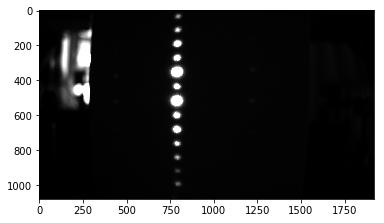

In [8]:
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()
#new_width = camera.Width.GetValue() - camera.Width.GetInc()
#if new_width >= camera.Width.GetMin():
#    camera.Width.SetValue(new_width)

# Make some enumerations available locally to avoid too much code:
ErrorCode = slmdisplaysdk.SLMDisplay.ErrorCode
ShowFlags = slmdisplaysdk.SLMDisplay.ShowFlags

# Initializes the SLM library
slm = slmdisplaysdk.SLMDisplay()

# Check if the library implements the required version
if not slm.requiresVersion(2):
    exit(1)

# Detect SLMs and open a window on the selected SLM
error = slm.open()
assert error == ErrorCode.NoError, slm.errorString(error)

# Open the SLM preview window in "Fit" mode:
# Please adapt the file showSLMPreview.py if preview window
# is not at the right position or even not visible.
from showSLMPreview import showSLMPreview
#showSLMPreview(slm, scale=0.0)

# Calculate e.g. a vertical blazed grating:
#blazePeriod = 77

# Reserve memory for the data:
dataWidth = slm.width_px
dataHeight = slm.height_px
data = slmdisplaysdk.createFieldUChar(dataWidth, dataHeight)
#print(data)
print("shape is: ", data.shape)
print("dataWidth = " + str(dataWidth))
print("dataHeight = " + str(dataHeight))

# Calculate the data:
data = 2*np.pi*np.random.rand(dataHeight, dataWidth)
print(data)
#Change Threshold
COST = 999999999999999999
Threshold = 0.1
a = 0.5
def cost(I_target, I_camera):
    return np.sum((abs(I_target-I_camera))**2)/np.size(I_target)

# Set this appropriately, can load the .npy file into this, and resize probably
TargetIntensity = np.load('target_intensity_05_10.npy')

print(TargetIntensity.shape)
plt.imshow(TargetIntensity, cmap='gray', vmin=0, vmax=255)
plt.show()

[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [128. 128. 128. ... 128. 128. 128.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [128. 128. 128. ... 128. 128. 128.]
 [128. 128. 128. ... 128. 128. 128.]]
(1080, 1920)


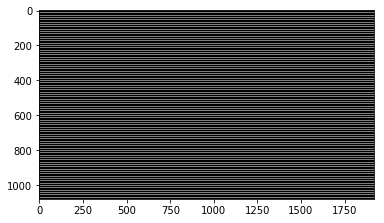

In [9]:
#target_phase = np.fromfile('target_phase_mask.dat.dat', dtype=np.int64)
target_phase = np.loadtxt('target_phase_mask.dat.dat')
print(target_phase)
print(target_phase.shape)
plt.imshow(target_phase, cmap='gray', vmin=0, vmax=255)
plt.show()

In [10]:
numberOfImagesToGrab = 50
target_phase = 2*np.pi*target_phase/255
data_init = data
data_error = []
data_error.append(cost(data_init, target_phase))
intensity_error = []
iter = 0
#new_target = TargetIntensity.T
time_start = time.time()
Threshold = 1
while iter in range(numberOfImagesToGrab) and (COST>Threshold):
    #error = slm.showData(data)
    error = slm.showPhasevalues(data)
    time.sleep(5)
    #input("Press Enter to continue...")
    
    camera.StartGrabbingMax(1)
    while camera.IsGrabbing():
        grabResult = camera.RetrieveResult(20000, pylon.TimeoutHandling_ThrowException)
        if grabResult.GrabSucceeded():
            # Access the image data.
            img = (np.asarray(grabResult.Array))**0.5 #.reshape((grabResult.Height, grabResult.Width))
        else:
            print("Error: ", grabResult.ErrorCode, grabResult.ErrorDescription)
        grabResult.Release()
            
            
    img_sliced = img[4:1084, 64:1984]
    
    COST = cost(TargetIntensity, img_sliced**2)
    intensity_error.append(COST)           
    
    img_fb = np.fft.fftshift(np.fft.ifft2((a*img_sliced+(1-a)*(TargetIntensity)**0.5)*(np.cos(data) + 1j*np.sin(data)))) # Multiplying phase mask to output electric field amplitude
    img_fb_phase = np.angle(img_fb)           

    data = img_fb_phase
    data = data%(2*np.pi)
    #data = ((255*data/(2*np.pi))%256)*2*np.pi/255
    data_error.append(cost(target_phase, data))
    iter = iter + 1    

    time2 = time.time()
    

print(data.shape)
print("TIME: ", time2-time_start)
print("Converged in ", iter , " iterations")

(1080, 1920)
TIME:  566.3044579029083
Converged in  50  iterations


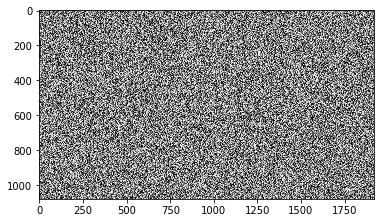

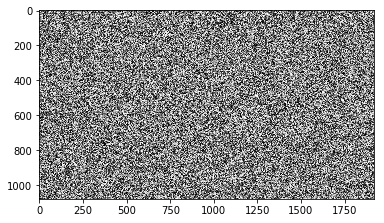

10826.048935439854
0.0
0.0
(1080, 1920)


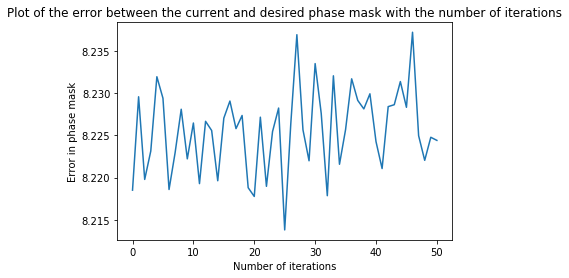

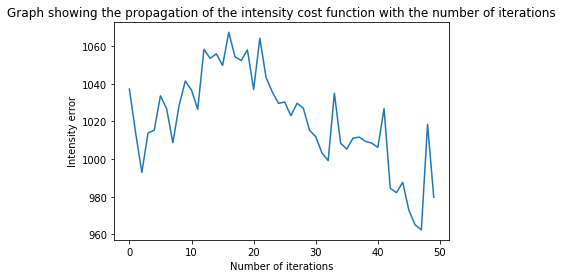

<Figure size 432x288 with 0 Axes>

In [12]:
data_final = data*255/(2*np.pi)
plt.imshow(data_final, cmap='gray', vmin=0, vmax=255)
plt.show()
np.save('algo_test_result_05_10', data)

#data_init = data_init*255/(2*np.pi)
plt.imshow(data_init, cmap='gray')
plt.show()
print(cost(data_final, data_init))
print(cost(data, data))
print(cost(data_init, data_init))

print(data_init.shape)
n = np.arange(0,51,1)
plt.plot(n, data_error)
plt.xlabel('Number of iterations')
plt.ylabel('Error in phase mask')
plt.title('Plot of the error between the current and desired phase mask with the number of iterations')
plt.show()
plt.savefig('mask_error_05_10.png')

m = np.arange(0,50,1)
plt.plot(m, intensity_error)
plt.xlabel('Number of iterations')
plt.ylabel('Intensity error')
plt.title('Graph showing the propagation of the intensity cost function with the number of iterations')
plt.show()
plt.savefig('intensity_error_05_10.png')